In [21]:
# Habilito el helper.ipynb
%run helper_fashion.ipynb

# En caso que no funcione puedo ver el path del kernel
#import os
#print(os.getcwd())

In [14]:
import numpy as np
import pandas as pd

from tensorflow import keras
from keras import layers
from keras.datasets import mnist
from keras.callbacks import EarlyStopping
from keras import backend as K

K.clear_session()

(x_train, y_train) , (x_test, y_test) = mnist.load_data() # 28x28
train_morpho = pd.read_csv("train-morpho.csv")  
test_morpho = pd.read_csv("t10k-morpho.csv")    # index, area, length, thickness, slant, width, height

# Normalizar los datos de entrada
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Separa las imágenes y tablas por categoría
clases = np.unique(y_train)
num_clases = len(clases)
imagenes_por_clase = [x_train[y_train == clase] for clase in clases]        # 10 arreglos de 6k matrices de 28x28
tablas_por_clase = [train_morpho[y_train == clase] for clase in clases]     # 10 arreglos de 6k arreglos de 7

# EDA

### Primero se graficó el promedio y la dispersión de las imágenes en train. 
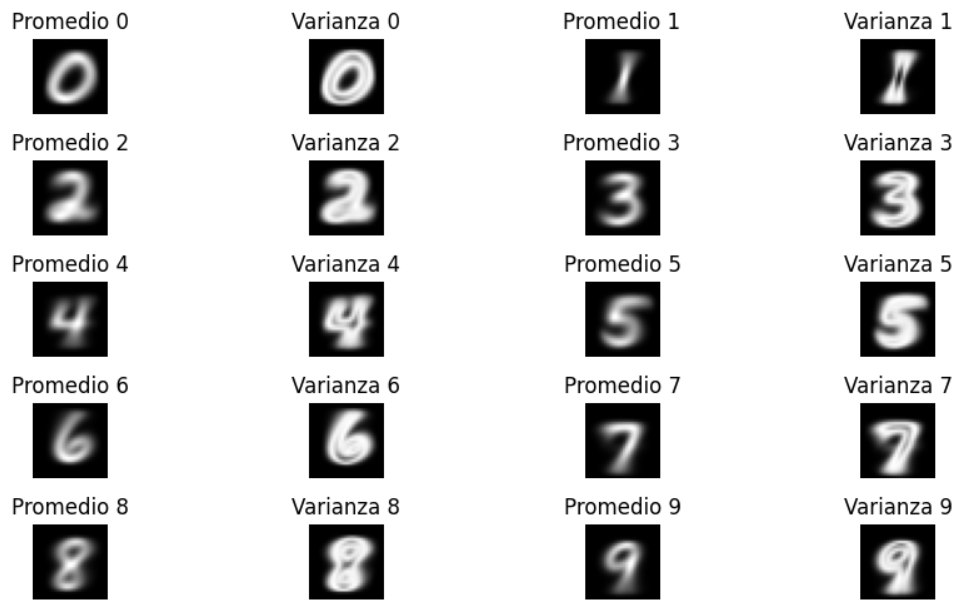

### Luego se analizaron los histogramas de inclinacion para cada clase.
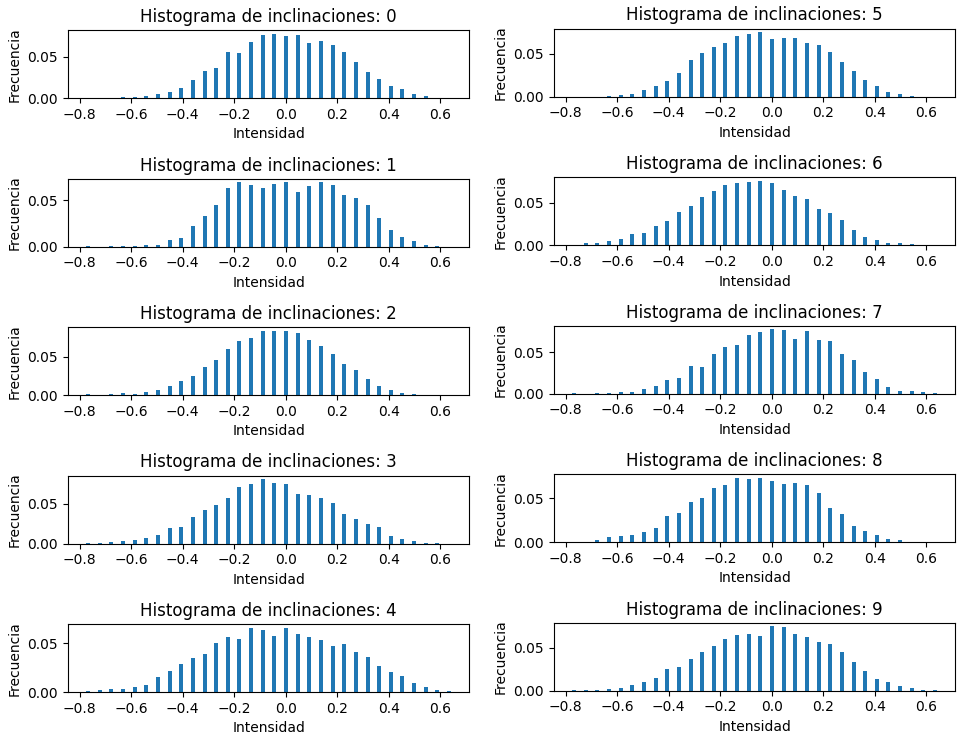

In [ ]:
promedio_varianza(x_train, y_train, num_clases, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

histogramas_de_inclinaciones(tablas_por_clase, num_clases, bins_num=32)

### Tambien se realizó un scatter entre las distintas variables, pero no se obtuvo ninguna conclusión a partir de dichos graficos. 

### Por este motivo, tambien se calcula la correlacion para obtener resultados en forma mas precisa, de que variable se relaciona mas con la inclinacion de los numeros, en terminos generales. Los resultados fueron los siguientes:
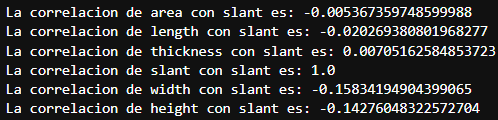

### En conclusión, la variable mas relacionada con el slant es el ancho.

In [ ]:
import matplotlib.pyplot as plt

# columnas
morpho_features = ["area", "length", "thickness", "slant", "width", "height"]

fig, axes = plt.subplots(nrows=len(morpho_features), figsize=(4, 4 * len(morpho_features)))

for i, feature in enumerate(morpho_features):
    ax = axes[i]
    ax.scatter(train_morpho[feature], train_morpho["slant"], alpha=0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel("Incline")
    ax.set_title(f"Scatter of slant vs. {feature}")

fig.tight_layout()

plt.show()

In [ ]:
correlation = []

for feature in morpho_features:
    correlation.append(train_morpho['slant'].corr(train_morpho[feature]))
        
for n in range(len(morpho_features)):
    print(f'La correlacion de {morpho_features[n]} con slant es: {str(correlation[n])}')

# Modelo

### En este caso se utilizo un modelo arbitrario que funcionara bien, ya que no se fijo un objetivo para el MAE deseado. Con un modelo de dos capas, se obtienen los siguientes resultados:
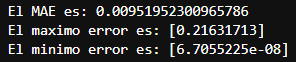

In [ ]:
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Crear el modelo de regresión
model = keras.Sequential()
model.add(Flatten(input_shape=(28, 28)))          
model.add(Dense(512, activation='relu', kernel_initializer='glorot_normal'))                   
model.add(Dense(128, activation='relu', kernel_initializer='glorot_normal'))          
model.add(Dense(1, activation='linear', kernel_initializer='glorot_normal'))

# Compilar el modelo
model.compile(loss="mae", optimizer=Adam(learning_rate=1e-3), metrics=["mae"])
early_stop = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', patience=3, factor=0.1, min_lr=1e-9)

# Entrenar el modelo
history = model.fit(
    x = x_train, 
    y = train_morpho['slant'].values, 
    batch_size = 200,   
    epochs = 200,     
    verbose = 1,
    validation_data = (x_test, test_morpho['slant'].values),   
    shuffle = False,   
    callbacks=[early_stop, reduce_lr]
) 

In [ ]:
# Evaluar el modelo en los datos de prueba
loss, mae = model.evaluate(x_test, test_morpho['slant'].values)

predict_slant = model.predict(x_test)# [sublista[1] for sublista in predictions]
error = [abs(x - y) for x, y in zip(predict_slant, test_morpho['slant'].values)]

print('El MAE es: ' + str(mae))
print('El maximo error es: ' + str(max(error)))
print('El minimo error es: ' + str(min(error)))

### Embeddings
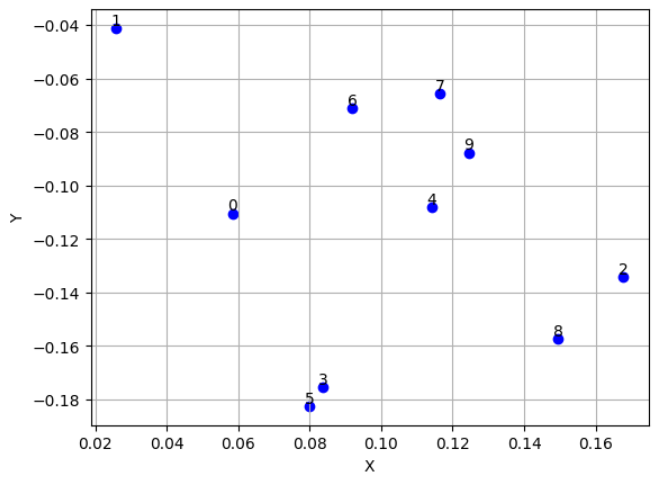

# Los puntos más cercanos representan a los números que mas se parecen entre sí.


In [ ]:
from keras.optimizers import Adam
from keras.layers import Input, Flatten, Embedding, Concatenate, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model

input_image = Input(shape=(28, 28))
flattened_image = Flatten()(input_image)
input_emb = Input(shape=(1, ))
embedding = Embedding(10, 2)(input_emb)
flattened_emb = Flatten()(embedding)
input2 = Concatenate()([flattened_image, flattened_emb])
relu1 = Dense(512, activation='relu', kernel_initializer='glorot_normal')(input2)
relu2 = Dense(128, activation='relu', kernel_initializer='glorot_normal')(relu1)
output2 = Dense(1, activation='linear', kernel_initializer='glorot_normal')(relu2)

model = Model(inputs=[input_image, input_emb], outputs=output2)

# Compilar el modelo
model.compile(loss="mae", optimizer=Adam(learning_rate=1e-3), metrics=["mae"])

early_stop = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', patience=3, factor=0.1, min_lr=1e-9)

# Entrenar el modelo
history = model.fit(
    x = [x_train, y_train], 
    y = train_morpho['slant'].values, 
    batch_size = 200,   
    epochs = 200,     
    verbose = 1,
    validation_data = ([x_test, y_test], test_morpho['slant'].values),   
    shuffle = False,   
    callbacks = [early_stop, reduce_lr]
)

emb_weights = model.layers[2].get_weights()[0]

In [ ]:
import matplotlib.pyplot as plt

# Example data points in 2D space
x = emb_weights[:, 0]
y = emb_weights[:, 1]
labels = class_names

# Plot the points
plt.scatter(x, y, c='b', marker='o')

# Label the points
for i, label in enumerate(labels):
    plt.text(x[i], y[i], label, ha='center', va='bottom')
    
# Set labels for the axes
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

# Show the plot
plt.show()

# Entrenamiento utilizando una variable continua

### Por lo analizado en el EDA, se agrego una entrada más, con el valor del width proporcionado en las tablas morpho. Se obtuvieron los siguientes resultados:
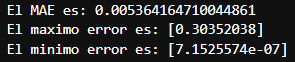

### Hay una pequeña respecto al item a en el MAE.

In [ ]:
from keras.layers import Input, concatenate
from keras.models import Model

input_image = Input(shape=(28, 28))
flattened_image = Flatten()(input_image)
input_width = Input(shape=(1, ))
input1 = concatenate([flattened_image, input_width])
relu1 = Dense(512, activation='relu', kernel_initializer='glorot_normal')(input1)
relu2 = Dense(128, activation='relu', kernel_initializer='glorot_normal')(relu1)
output1 = Dense(1, activation='linear', kernel_initializer='glorot_normal')(relu2)

model = Model(inputs=[input_image, input_width], outputs=output1)

# Compilar el modelo con los callbacks
model.compile(loss="mae", optimizer=Adam(learning_rate=1e-3), metrics=["mae"])

# Entrenar el modelo
history = model.fit(
    x = [x_train, train_morpho['width'].values], 
    y = train_morpho['slant'], 
    batch_size = 200,   
    epochs = 200,     
    verbose = 1,
    validation_data = ([x_test, test_morpho['width'].values], test_morpho['slant'].values),   
    shuffle = False,   
    callbacks = [early_stop, reduce_lr]
) 

In [52]:
# Evaluar el modelo en los datos de prueba
loss, mae = model.evaluate([x_test, test_morpho['width'].values], test_morpho['slant'].values)

predict_slant = model.predict([x_test, test_morpho['width'].values])    # [sublista[1] for sublista in predictions]
error = [abs(x - y) for x, y in zip(predict_slant, test_morpho['slant'])]

print('El MAE es: ' + str(mae))
print('El maximo error es: ' + str(max(error)))
print('El minimo error es: ' + str(min(error)))

313/313 [==============================] - 1s 4ms/step
El MAE es: 0.005364164710044861
El maximo error es: [0.30352038]
El minimo error es: [7.1525574e-07]
